# COMP5900 K Final Project: A Study of Backporting in npm, PyPi and Maven Ecosystems

### Authors: Samin Azhan (SaminAzhan@cmail.carleton.ca) and Elmira Adeeb (ElmiraAdeeb@cmail.carleton.ca)

##### The data of the project was collected and extracted from Libraries.io (version 1.6): https://libraries.io/data

In [30]:
import pandas
import numpy as np
import matplotlib
import seaborn

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

from IPython.display import display

%matplotlib inline


In [31]:
FIG_SIZE = (6, 3)
FIG_SIZE_WIDE = (9, 3)

ECOSYSTEMS = ['npm', 'PyPi', 'Maven']
DATE_RANGE = pandas.to_datetime('2015-01-01', utc=True), pandas.to_datetime('2020-01-01', utc=True)
CENSOR_DATE = pandas.to_datetime('2020-01-12', utc=True)

PALETTE = seaborn.color_palette()
PAL_REL = np.take(seaborn.color_palette('muted'), [3, 8, 2, 0], axis=0)
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

SAVEFIG = True

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

savefig = _savefig if SAVEFIG else lambda x, y: None


## Survey Results
From the survey at https://kilthub.cmu.edu/articles/dataset/Culture_and_Breaking_Change_A_Survey_of_Values_and_Practices_in_18_Open_Source_Software_Ecosystems/5108716

In [32]:
survey = {
    # Disagree / agree
    'npm': [39, 14],
    'PyPi': [43, 12],
    'Maven': [20, 11]
}

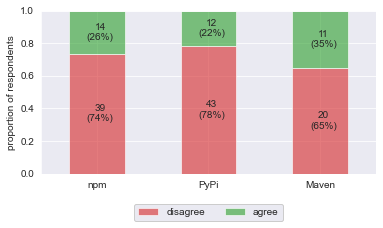

In [33]:
fig, ax = matplotlib.pyplot.subplots()

_ = (
    pandas.DataFrame(survey, index=['disagree', 'agree'])
    .T
    .loc[ECOSYSTEMS]
)

_.apply(lambda s: s / s.sum(), axis=1).plot.bar(
    color=PALETTE[3::-1],
    alpha=0.6,
    stacked=True,
    ax=ax
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    total = _.loc[ecosystem].sum()
    disagree = _.at[ecosystem, 'disagree']
    agree = _.at[ecosystem, 'agree']
    ax.annotate('{:}\n({:.0%})'.format(disagree, disagree / total), (i + 0.03, disagree / total / 2), ha='center', va='center')

    if agree > 0:
        ax.annotate('{:}\n({:.0%})'.format(agree, agree / total), (i + 0.03, 1 - (agree / total / 2)), ha='center', va='center')

ax.set(
    xlabel='',
    ylabel='proportion of respondents',
    ylim=(0, 1),
)
ax.xaxis.set_tick_params(rotation=0)

ax.legend(
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.32),
)

savefig(fig, 'backporting-agreement-2')

## Data Overview


### Loading Data for npm, PyPi and Maven

In [34]:
df_required = dict()
df_dependents = dict()

for ecosystem in ECOSYSTEMS:
    # Changing "NPM" to "npm"
    if ecosystem == 'npm':
        e = 'NPM'
    # Changing "Pypi" to "PyPi"
    elif ecosystem == 'PyPi':
        e = 'Pypi'
    else: e = ecosystem

    print('Loading', ecosystem)
    print('.. required packages')
    df_required[ecosystem] = (
        pandas.read_csv(
            'data/{}-required.csv.gz'.format(e),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
    )

    print('.. dependent packages')
    df_dependents[ecosystem] = (
        pandas.read_csv(
            'data/{}-dependents.csv.gz'.format(e),
        )
    )

print('Done!')


Loading npm
.. required packages
.. dependent packages
Loading PyPi
.. required packages
.. dependent packages
Loading Maven
.. required packages
.. dependent packages
Done!


### Data Cleaning


We will be removing packages having the following properties:
-Step 1: Version numbers do not follow a chronological order
-Step 2: A release precedes the release date of its corresponding major.


In [35]:
filter_1 = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['kind'].isin(['major', 'initial'])]
    [['package', 'rank', 'rank_date']]
    .sort_values('rank')
    # (1) and (2)
    .groupby('package', sort=False, as_index=False)
    .agg({
        'rank_date': lambda s: s.rank().is_monotonic,
    })
    .query('not rank_date')
    [['package']]
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package']]
    for ecosystem in ECOSYSTEMS]
)


In [36]:
(
     filter_1
    .groupby('ecosystem')
    .count()
)


,package
ecosystem,
Maven,5
PyPi,17
npm,183


In [37]:
filter_2 = pandas.concat([
    df_required[ecosystem]
    [lambda d: d['package'].isin(
        df_required[ecosystem]
        .sort_values('rank_date')
        .groupby(['package', 'major'], sort=False, as_index=False)
        .first()
        .query('kind not in ["major", "initial"]')
        .package
    )]
    [['package']]
    .drop_duplicates()
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package']]
    for ecosystem in ECOSYSTEMS]
)


In [38]:
(
     filter_2
    .groupby('ecosystem')
    .count()
)


,package
ecosystem,
Maven,9
PyPi,28
npm,197


In [39]:
data = filter_1.append(filter_2)


In [40]:
(
    data
    .groupby('ecosystem')
    .count()
)


,package
ecosystem,
Maven,14
PyPi,45
npm,380


Removing these packages and related dependencies


In [41]:
for ecosystem in ECOSYSTEMS:
    packages = data[lambda d: d['ecosystem'] == ecosystem].package
    df_required[ecosystem] = df_required[ecosystem][lambda d: ~d['package'].isin(packages)]
    df_dependents[ecosystem] = df_dependents[ecosystem][lambda d: ~d['target'].isin(packages)]


### Updated Dataset


In [42]:
data = pandas.DataFrame(index=['required', 'releases', 'dependents', 'dependencies'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['required', ecosystem] = len(df_required[ecosystem].drop_duplicates('package'))
    data.at['releases', ecosystem] = len(df_required[ecosystem])
    data.at['dependents', ecosystem] = len(df_dependents[ecosystem].drop_duplicates('source'))
    data.at['dependencies', ecosystem] = len(df_dependents[ecosystem])

data


,npm,PyPi,Maven
required,15281,704,217
releases,570676,29896,11562
dependents,242618,14370,1859
dependencies,1021843,28498,3512


In [43]:
data.T[['required', 'releases', 'dependents', 'dependencies']].sum()


required          16202
releases         612134
dependents       258847
dependencies    1053853
dtype: object

## RQ1: How many packages still depend on older versions?


In [48]:
data = pandas.concat([
    df_dependents[ecosystem]
    [['source', 'target', 'selected']]
    # Get highest release of target package
    .merge(
        df_required[ecosystem]
        .drop_duplicates('package', keep='last')
        [['package', 'major', 'minor', 'patch']],
        how='inner',
        left_on='target',
        right_on='package',
    )
    # Get release for selected one
    .merge(
        df_required[ecosystem]
        [['package', 'rank', 'major', 'minor', 'patch']],
        how='inner',
        left_on=['target', 'selected'],
        right_on=['package', 'rank'],
        suffixes=(None, '_selected'),
    )
    .drop(columns=['package', 'package_selected', 'rank'])
    # Identify release being used
    .eval('''
        latest = major_selected == major and minor_selected == minor and patch_selected == patch
        previous_major = major_selected < major
        previous_minor = major_selected == major and minor_selected < minor
        previous_patch = major_selected == major and minor_selected == minor and patch_selected < patch
    ''')
    .assign(kind=lambda d: d[['latest', 'previous_major', 'previous_minor', 'previous_patch']].idxmax(axis=1))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'kind', 'major_selected', 'major']]
    for ecosystem in ECOSYSTEMS],
)


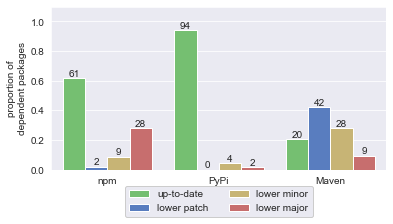

In [51]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    .groupby(['ecosystem', 'kind'])
    .agg({'source': 'count'})
    .div(
        data
        .groupby('ecosystem')
        .agg({'source': 'count'})
    )
    .reset_index()
    .replace({'kind': {'latest': 'up-to-date', 'previous_major': 'lower major', 'previous_minor': 'lower minor', 'previous_patch': 'lower patch'}})
)

seaborn.barplot(
    x='ecosystem',
    y='source',
    hue='kind',
    hue_order=['up-to-date', 'lower patch', 'lower minor', 'lower major'],
    order=ECOSYSTEMS,
    data=temp,
    palette=np.take(PAL_REL, [2, 3, 1, 0], axis=0),
    ax=ax
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, label in enumerate(['up-to-date', 'lower patch', 'lower minor', 'lower major']):
        value = temp[lambda d: (d['ecosystem'] == ecosystem) & (d['kind'] == label)].iloc[0].source
        x = i + (j * 0.2 - 0.30)
        ax.annotate('{:.0f}'.format(value * 100), (x, value + 0.03), ha='center', va='center')

ax.legend(ncol=2, loc='lower center',
    bbox_to_anchor=(0.5, -0.32))

ax.set(
    xlabel='',
    ylabel='proportion of\ndependent packages',
    ylim=(0, 1.1),
)

savefig(fig, 'need_used_release')


In [46]:
(
    pandas.crosstab(data['ecosystem'], data['kind'], normalize='index', margins=True)
    .style.format('{:.1%}').background_gradient(vmin=0, vmax=1)
)


kind,latest,previous_major,previous_minor,previous_patch
ecosystem,,,,
Maven,20.4%,9.4%,28.0%,42.3%
PyPi,93.9%,1.6%,4.5%,0.0%
npm,61.5%,27.7%,8.7%,2.0%
All,62.1%,27.1%,8.7%,2.1%


### Behind by how many major trains?


In [47]:
temp = pandas.concat([
    df_required[ecosystem]
    [['package', 'major']]
    .drop_duplicates()
    .assign(major_rank=lambda d: d.groupby('package').cumcount() + 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
)

(
    data
    [lambda d: d['kind'] == 'previous_major']
    .merge(
        temp,
        how='left',
        left_on=['ecosystem', 'target', 'major_selected'],
        right_on=['ecosystem', 'package', 'major'],
    )
    .drop(columns=['package', 'major_y'])
    .rename(columns={'major_x': 'major', 'major_rank': 'major_rank_selected'})
    .merge(
        temp,
        how='left',
        left_on=['ecosystem', 'target', 'major'],
        right_on=['ecosystem', 'package', 'major'],
    )
    [['ecosystem', 'source', 'target', 'major_selected', 'major_rank_selected', 'major', 'major_rank']]
    .eval('diff = major_rank - major_rank_selected')
    .assign(diff=lambda d: d['diff'].where(d['diff'] < 4, '4+'))
    .groupby(['ecosystem', 'diff'])
    [['source']]
    .count()
    .unstack()
    .fillna(0)
    .apply(lambda s: s / s.sum(), axis=1)
    .style
    .format('{:.1%}')
)


## RQ2: How much backporting exists in the selected package distribution systems?


In [52]:
data = pandas.concat([
    df_required[ecosystem]
    .assign(
        pkg_first=lambda d: ~d['package'].duplicated(),
        backport_first=lambda d: ~d[['package', 'backported']].duplicated() & d['backported'],
        release=1,
        backports=lambda d: d['backported'].astype(int),
    )
    .set_index('date')
    [['pkg_first', 'backport_first', 'release', 'backports']]
    .sort_index()
    .cumsum()
    .assign(
        packages=lambda d: d['backport_first'] / d['pkg_first'],
        releases=lambda d: d['backports'] / d['release'],
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)


In [53]:
(
    data
    .groupby('ecosystem')
    .last()
)


,pkg_first,backport_first,release,backports,packages,releases
ecosystem,,,,,,
Maven,217,47,11562,370,0.216590,0.032001
PyPi,704,56,29896,337,0.079545,0.011272
npm,15281,1010,570676,6425,0.066095,0.011259


In [54]:
(
    pandas.concat([
        df_required[ecosystem]
        .groupby('package', sort=False, as_index=False)
        .agg({'backported': 'max', 'major': 'nunique'})
        [lambda d: d['major']  > 1]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS]
    )
    .groupby('ecosystem')
    .agg({'package': 'count', 'backported': 'sum'})
    .assign(p=lambda d: d['backported'] / d['package'])
)


,package,backported,p
ecosystem,,,
Maven,105,47,0.447619
PyPi,404,56,0.138614
npm,8870,1010,0.113867


### Visualizing the proportion of packages in npm

In [59]:
data = pandas.concat([
    df_required[ecosystem]
    # Keep only packages with backported releases
    .groupby('package', sort=False, as_index=False)
    .filter(lambda g: g['backported'].max())
    # Identify major branches
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg({'backported': 'max'})
    .groupby('package', sort=False, as_index=False)
    .agg({'major': 'count', 'backported': 'sum'})
    .assign(proportion=lambda d: d['backported'] / d['major'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ['npm']]
)

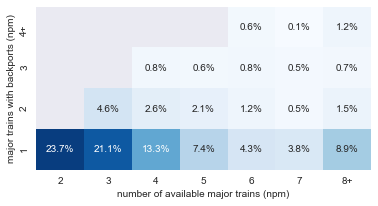

In [60]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(
            major=lambda d: d['major'].where(d['major'] < 8, '8+'),
            backported=lambda d: d['backported'].astype(str).where(d['backported'] < 4, '4+'),
        )
        .groupby(['major', 'backported'], as_index=False)
        .agg({'package': 'count'})
        .pivot(index='major', columns='backported', values='package')
        .div(len(data))
        .T
        .sort_index(ascending=False)
    ),
    vmin=0,
    vmax=0.25,
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of available major trains (npm)',
    ylabel='major trains with backports (npm)',
)

savefig(fig, 'prev_prop_major_with_backports_npm')


### Visualizing the proportion of packages in PyPi

In [62]:
data = pandas.concat([
    df_required[ecosystem]
    # Keep only packages with backported releases
    .groupby('package', sort=False, as_index=False)
    .filter(lambda g: g['backported'].max())
    # Identify major branches
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg({'backported': 'max'})
    .groupby('package', sort=False, as_index=False)
    .agg({'major': 'count', 'backported': 'sum'})
    .assign(proportion=lambda d: d['backported'] / d['major'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ['PyPi']]
)

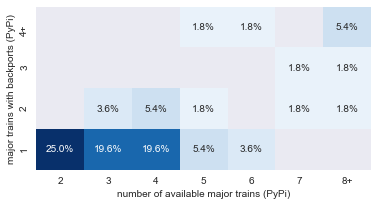

In [63]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(
            major=lambda d: d['major'].where(d['major'] < 8, '8+'),
            backported=lambda d: d['backported'].astype(str).where(d['backported'] < 4, '4+'),
        )
        .groupby(['major', 'backported'], as_index=False)
        .agg({'package': 'count'})
        .pivot(index='major', columns='backported', values='package')
        .div(len(data))
        .T
        .sort_index(ascending=False)
    ),
    vmin=0,
    vmax=0.25,
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of available major trains (PyPi)',
    ylabel='major trains with backports (PyPi)',
)

savefig(fig, 'prev_prop_major_with_backports_PyPi')


### Visualizing the proportion of packages in Maven

In [64]:
data = pandas.concat([
    df_required[ecosystem]
    # Keep only packages with backported releases
    .groupby('package', sort=False, as_index=False)
    .filter(lambda g: g['backported'].max())
    # Identify major branches
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg({'backported': 'max'})
    .groupby('package', sort=False, as_index=False)
    .agg({'major': 'count', 'backported': 'sum'})
    .assign(proportion=lambda d: d['backported'] / d['major'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ['Maven']]
)

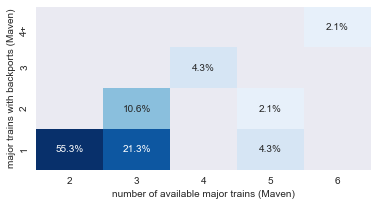

In [65]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(
            major=lambda d: d['major'].where(d['major'] < 8, '8+'),
            backported=lambda d: d['backported'].astype(str).where(d['backported'] < 4, '4+'),
        )
        .groupby(['major', 'backported'], as_index=False)
        .agg({'package': 'count'})
        .pivot(index='major', columns='backported', values='package')
        .div(len(data))
        .T
        .sort_index(ascending=False)
    ),
    vmin=0,
    vmax=0.25,
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of available major trains (Maven)',
    ylabel='major trains with backports (Maven)',
)

savefig(fig, 'prev_prop_major_with_backports_Maven')


### Visualizing the proportion of packages (regardless of the ecosystem) for each case:


In [57]:
data = pandas.concat([
    df_required[ecosystem]
    # Keep only packages with backported releases
    .groupby('package', sort=False, as_index=False)
    .filter(lambda g: g['backported'].max())
    # Identify major branches
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg({'backported': 'max'})
    .groupby('package', sort=False, as_index=False)
    .agg({'major': 'count', 'backported': 'sum'})
    .assign(proportion=lambda d: d['backported'] / d['major'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

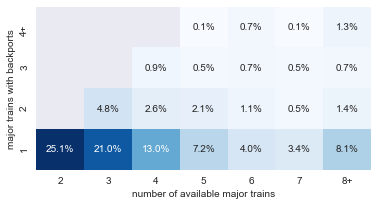

In [58]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.heatmap(
    data=(
        data
        .assign(
            major=lambda d: d['major'].where(d['major'] < 8, '8+'),
            backported=lambda d: d['backported'].astype(str).where(d['backported'] < 4, '4+'),
        )
        .groupby(['major', 'backported'], as_index=False)
        .agg({'package': 'count'})
        .pivot(index='major', columns='backported', values='package')
        .div(len(data))
        .T
        .sort_index(ascending=False)
    ),
    vmin=0,
    vmax=0.25,
    annot=True,
    cmap='Blues',
    fmt='.1%',
    cbar=False,
    cbar_kws={'label': 'proportion of packages'},
    ax=ax
)

ax.set(
    xlabel='number of available major trains',
    ylabel='major trains with backports',
)

savefig(fig, 'prev_prop_major_with_backports_all')


## RQ3: Do packages with backports exhibit different characteristics?


### Lifespan of packages with and without backports


In [73]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby(['package'], sort=False, as_index=False)
    .agg(
        first=('date', 'min'),
        last=('date', 'max'),
        releases=('version', 'count'),
        backports=('backported', 'sum'),
        backport=('backported', 'max'),
    )
    # Remove single release packages, since age is 0 and frequency is inf
    [lambda d: d['releases'] > 1]
    .assign(age=lambda d: (d['last'] - d['first']) / pandas.to_timedelta('365 days'))
    .assign(frequency=lambda d: (d['releases'] - d['backports']) / d['age'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS], axis=0
)


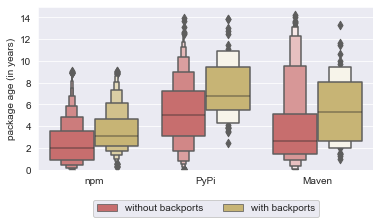

In [74]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='age',
    hue='backport',
    data=(
        data
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='lower center',
    bbox_to_anchor=(0.5, -0.32))

ax.set(
    xlabel='',
    ylabel='package age (in years)',
    ylim=(0, 15),
)

savefig(fig, 'char_package_age')


In [75]:
print(
    data
    .groupby(['ecosystem', 'backport'])
    .age.describe()
    .to_string()
)


                      count      mean       std       min       25%       50%       75%        max
ecosystem backport                                                                                
Maven     False       169.0  4.139068  3.796089  0.016438  1.394137  2.600043  5.160980  14.250941
          True         47.0  5.503433  3.148047  1.005363  2.672732  5.258554  8.053106  13.313203
PyPi      False       648.0  5.214540  2.953159  0.000507  3.060383  4.983150  7.219294  13.982982
          True         56.0  7.425181  2.868222  2.448879  5.474942  6.735812  9.451860  13.866868
npm       False     13838.0  2.406072  1.898542  0.000001  0.865093  2.014469  3.525708   9.037212
          True       1010.0  3.586221  1.932858  0.251463  2.156691  3.128774  4.690842   9.064915


In [76]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] > 0)].age
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] == 0)].age
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)

    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))


npm        with vs. without: p=0.00000; d=0.367 (medium)
PyPi       with vs. without: p=0.00000; d=0.408 (medium)
Maven      with vs. without: p=0.00039; d=0.321 (small)


### Release frequency of packages with and without backports


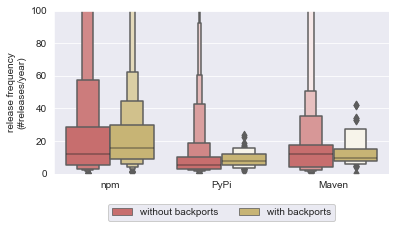

In [77]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='frequency',
    hue='backport',
    data=(
        data
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='lower center',
    bbox_to_anchor=(0.5, -0.32))

ax.set(
    xlabel='',
    ylabel='release frequency\n(#releases/year)',
    ylim=(0, 100),
)

savefig(fig, 'char_package_frequency')


In [78]:
print(
    data
    .groupby(['ecosystem', 'backport'])
    .frequency.describe()
    [['count', 'mean', '50%']]
    .to_string()
)


                      count        mean        50%
ecosystem backport                                
Maven     False       169.0   19.772497  12.102323
          True         47.0   13.626298   9.332654
PyPi      False       648.0   21.252324   5.328641
          True         56.0    9.078155   7.569505
npm       False     13838.0  972.990056  11.996832
          True       1010.0   29.671051  15.999950


In [79]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] > 0)].frequency
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backport'] == 0)].frequency
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)

    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))


npm        with vs. without: p=0.00000; d=0.150 (small)
PyPi       with vs. without: p=0.00250; d=0.226 (small)
Maven      with vs. without: p=0.44335; d=0.014 (negligible)


### Number of dependent packages with and without backports


In [80]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)


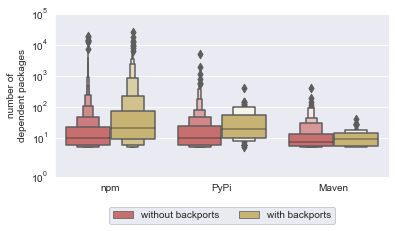

In [81]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='dependents',
    hue='backports',
    data=(
        data
        .assign(backports=lambda d: d['backports'] > 0)
        .replace({'backports': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='lower center',
    bbox_to_anchor=(0.5, -0.32))

ax.set(
    xlabel='',
    ylabel='number of\ndependent packages',
    yscale='symlog',
    ylim=(1, 10e4),
)

savefig(fig, 'prev_backport_dependents')


In [82]:
(
    data
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['dependents']].describe())
    .unstack()
)


dependents                                       \
                                 count        mean          std  min    25%   
ecosystem backports                                                           
Maven     with backports          47.0   11.553191     7.711675  5.0   5.50   
          without backports      170.0   17.464706    37.335540  5.0   5.25   
PyPi      with backports          56.0   41.821429    62.045176  5.0  10.00   
          without backports      648.0   40.364198   219.559564  5.0   6.00   
npm       with backports        1010.0  279.304950  1360.764012  5.0   9.00   
          without backports    14271.0   51.835541   373.278294  5.0   6.00   

                                                   
                              50%    75%      max  
ecosystem backports                                
Maven     with backports      9.0  14.00     39.0  
          without backports   7.0  13.00    397.0  
PyPi      with backports     18.5  55.50    399.0  
          without backports  10.0  23.25   4883.0  
npm       with backports     20.0  72.00  26163.0  
          without backports  10.0  22.00  18354.0

In [83]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] > 0)].dependents
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['backports'] == 0)].dependents
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)

    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))


npm        with vs. without: p=0.00000; d=0.311 (small)
PyPi       with vs. without: p=0.00004; d=0.316 (small)
Maven      with vs. without: p=0.30190; d=0.049 (negligible)


## RQ4: Does backporting affect the upkeep of lower major releases?


### Lifespan of lower major trains with and without backports


In [84]:
data = pandas.concat([
    df_required[ecosystem]
    .groupby(['package', 'major'], sort=False, as_index=False)
    .agg(
        backport=('backported', 'max'),
        date_first=('date', 'first'),
        date_last=('date', 'last'),
        rank_first=('rank', 'first'),
        rank_last=('rank', 'last'),
    )
    .assign(time=lambda d: (d['date_last'] - d['date_first']) / pandas.to_timedelta('30 day'))
    .assign(versions=lambda d: d['rank_last'] - d['rank_first'] + 1)
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
)


In [85]:
temp = (
    data
    .groupby(['ecosystem', 'package'], sort=False)
    .filter(lambda g: g['backport'].max())
    .sort_values('major')
    .groupby(['ecosystem', 'package'], as_index=False, sort=False)
    .apply(lambda g: g.iloc[:-1])
)


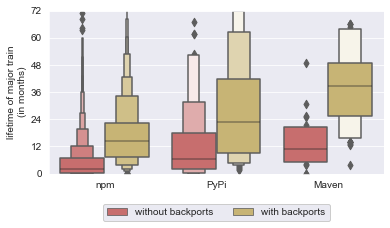

In [86]:
fig, ax = matplotlib.pyplot.subplots()

seaborn.boxenplot(
    x='ecosystem',
    y='time',
    hue='backport',
    data=(
        temp
        .replace({'backport': {True: 'with backports', False: 'without backports'}})
    ),
    order=ECOSYSTEMS,
    palette=PAL_REL,
    ax=ax,
)

ax.legend(title=None, ncol=2, loc='lower center',
    bbox_to_anchor=(0.5, -0.32))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=12))

ax.set(
    xlabel='',
    ylabel='lifetime of major train\n(in months)',
    ylim=(0, 72),
)

savefig(fig, 'support_time_restricted')


In [87]:
print(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['time'].describe())
    .to_string()
)


time                 count       mean        std       min        25%        50%        75%         max
ecosystem backport                                                                                     
Maven     False       18.0  13.663653  12.704368  0.000000   4.921752  10.765918  20.689320   48.810062
          True        61.0  40.961066  23.803336  4.000000  25.652873  38.735617  48.736078  123.639315
PyPi      False       87.0  13.840673  18.110929  0.000000   1.970491   6.655585  17.728548   76.084005
          True        88.0  29.949080  26.554903  1.537065   9.208001  22.702155  41.955896  114.853694
npm       False     2380.0   5.394059   8.397848  0.000000   0.237647   2.250098   6.866002   73.408870
          True      1279.0  17.559939  14.411895  0.000095   7.204307  14.457792  22.405671   91.062278


In [88]:
(
    temp
    .groupby(['ecosystem', 'backport'])
    .apply(lambda d: d['time'].describe())
    ['50%']
    .unstack()
    .assign(ratio=lambda d: d[True] / d[False])
)


backport,False,True,ratio
ecosystem,,,
Maven,10.765918,38.735617,3.597985
PyPi,6.655585,22.702155,3.410993
npm,2.250098,14.457792,6.425406


In [89]:
(
    temp
    .groupby(['ecosystem', 'package', 'backport'])
    .agg({'time': 'mean'})
    .unstack()
    ['time']
    .assign(ratio=lambda d: d[True] / d[False])
    [lambda d: d['ratio'] != np.inf]
    .groupby(['ecosystem'])
    .agg(mean=('ratio', 'mean'), median=('ratio', 'median'))
)


,mean,median
ecosystem,,
Maven,3.101547,3.556914
PyPi,3.164018,1.674874
npm,1148.183187,2.107005


In [90]:
for ecosystem in ECOSYSTEMS:
    A = temp[lambda d: (d['ecosystem'] == ecosystem) & d['backport']].time
    B = temp[lambda d: (d['ecosystem'] == ecosystem) & ~d['backport']].time
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)

    print('{:10} with vs. without: p={:.5f}; d={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))


npm        with vs. without: p=0.00000; d=0.666 (large)
PyPi       with vs. without: p=0.00000; d=0.470 (medium)
Maven      with vs. without: p=0.00000; d=0.772 (large)


### Major trains and backporting

In [94]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS]
)

In [95]:
(
    data
    [lambda d: d['major'] >= 2]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)

used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
Maven     with backports          47.0  1.382979  0.677373  0.0  1.0  1.0   
          without backports       58.0  1.310345  0.598445  0.0  1.0  1.0   
PyPi      with backports          56.0  1.500000  0.894427  1.0  1.0  1.0   
          without backports      348.0  1.218391  0.633826  0.0  1.0  1.0   
npm       with backports        1010.0  2.526733  1.630294  0.0  2.0  2.0   
          without backports     7860.0  1.948728  1.221407  0.0  1.0  2.0   

                                        
                             75%   max  
ecosystem backports                     
Maven     with backports     2.0   3.0  
          without backports  2.0   4.0  
PyPi      with backports     2.0   5.0  
          without backports  1.0   6.0  
npm       with backports     3.0  15.0  
          without backports  2.0  30.0

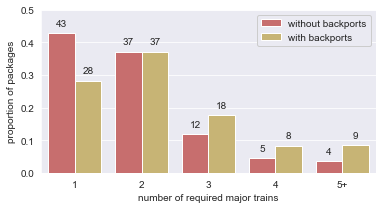

In [96]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    [lambda d: (d['major'] >= 2) & (d['used_major'] >= 1)]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 5, '5+'))
    .groupby(['used_major', 'backports'])
    .agg({'package': 'count'})
    .groupby('backports')
    .apply(lambda g: g / g.sum())
    .reset_index()
)


seaborn.barplot(
    x='used_major',
    y='package',
    hue='backports',
    hue_order=['without backports', 'with backports'],
    data=temp,
    palette=PAL_REL,
    ax=ax,
)


for i, backports in enumerate(['without backports', 'with backports']):
    for j, label in enumerate([1, 2, 3, 4, '5+']):
        value = temp[lambda d: (d['backports'] == backports) & (d['used_major'] == label)].iloc[0].package
        x = j - 0.20 if i == 0 else j + 0.20
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=1)

ax.set(
    xlabel='number of required major trains',
    ylabel='proportion of packages',
    ylim=(0, 0.5),
)

savefig(fig, 'prev_backport_used_major_barplot')


#### Visualizing for npm


In [97]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ['npm']]
)
(
    data
    [lambda d: d['major'] >= 2]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)


used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
npm       with backports        1010.0  2.526733  1.630294  0.0  2.0  2.0   
          without backports     7860.0  1.948728  1.221407  0.0  1.0  2.0   

                                        
                             75%   max  
ecosystem backports                     
npm       with backports     3.0  15.0  
          without backports  2.0  30.0

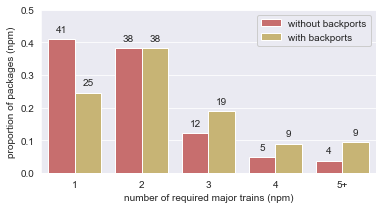

In [98]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    [lambda d: (d['major'] >= 2) & (d['used_major'] >= 1)]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 5, '5+'))
    .groupby(['used_major', 'backports'])
    .agg({'package': 'count'})
    .groupby('backports')
    .apply(lambda g: g / g.sum())
    .reset_index()
)


seaborn.barplot(
    x='used_major',
    y='package',
    hue='backports',
    hue_order=['without backports', 'with backports'],
    data=temp,
    palette=PAL_REL,
    ax=ax,
)


for i, backports in enumerate(['without backports', 'with backports']):
    for j, label in enumerate([1, 2, 3, 4, '5+']):
        value = temp[lambda d: (d['backports'] == backports) & (d['used_major'] == label)].iloc[0].package
        x = j - 0.20 if i == 0 else j + 0.20
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=1)

ax.set(
    xlabel='number of required major trains (npm)',
    ylabel='proportion of packages (npm)',
    ylim=(0, 0.5),
)

savefig(fig, 'prev_backport_used_major_barplot_npm')


#### Visualizing for PyPi


In [106]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ['PyPi']]
)
(
    data
    [lambda d: d['major'] >= 2]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)


used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
PyPi      with backports          56.0  1.500000  0.894427  1.0  1.0  1.0   
          without backports      348.0  1.218391  0.633826  0.0  1.0  1.0   

                                       
                             75%  max  
ecosystem backports                    
PyPi      with backports     2.0  5.0  
          without backports  1.0  6.0

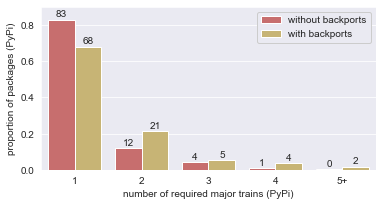

In [101]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    [lambda d: (d['major'] >= 2) & (d['used_major'] >= 1)]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 5, '5+'))
    .groupby(['used_major', 'backports'])
    .agg({'package': 'count'})
    .groupby('backports')
    .apply(lambda g: g / g.sum())
    .reset_index()
)


seaborn.barplot(
    x='used_major',
    y='package',
    hue='backports',
    hue_order=['without backports', 'with backports'],
    data=temp,
    palette=PAL_REL,
    ax=ax,
)


for i, backports in enumerate(['without backports', 'with backports']):
    for j, label in enumerate([1, 2, 3, 4, '5+']):
        value = temp[lambda d: (d['backports'] == backports) & (d['used_major'] == label)].iloc[0].package
        x = j - 0.20 if i == 0 else j + 0.20
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=1)

ax.set(
    xlabel='number of required major trains (PyPi)',
    ylabel='proportion of packages (PyPi)',
    ylim=(0, 0.9),
)

savefig(fig, 'prev_backport_used_major_barplot_PyPi')


#### Visualizing for Maven


In [148]:
data = pandas.concat([
    df_required[ecosystem]
    # Get dependents for each release
    .merge(
        df_dependents[ecosystem]
        [['source', 'target', 'selected']],
        how='left',
        left_on=['package', 'rank'],
        right_on=['target', 'selected']
    )
    # Group per major release, and count dependents
    .groupby(['package', 'major'], as_index=False)
    .agg({'source': 'count', 'backported': 'sum'})
    # For each package, get nb major, used major, dependents and backports
    .assign(used_major=lambda d: d['source'] > 0)
    .groupby('package', as_index=False, sort=False)
    .agg(
        major=('major', 'count'),
        used_major=('used_major', 'sum'),
        backports=('backported', 'sum')
    )
    .merge(
        df_dependents[ecosystem]
        .groupby('target', sort=False, as_index=False)
        .agg(dependents=('source', 'count')),
        how='left',
        left_on='package',
        right_on='target',
    )
    .assign(ecosystem=ecosystem)
    for ecosystem in ['Maven']]
)
(
    data
    [lambda d: d['major'] >= 2]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .groupby(['ecosystem', 'backports'])
    .apply(lambda g: g[['used_major']].describe())
    .unstack()
)


used_major                                     \
                                 count      mean       std  min  25%  50%   
ecosystem backports                                                         
Maven     with backports          47.0  1.382979  0.677373  0.0  1.0  1.0   
          without backports       58.0  1.310345  0.598445  0.0  1.0  1.0   

                                       
                             75%  max  
ecosystem backports                    
Maven     with backports     2.0  3.0  
          without backports  2.0  4.0

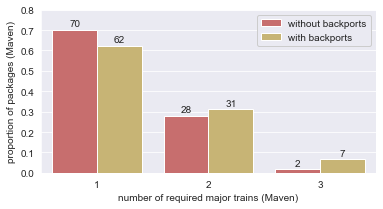

In [149]:
fig, ax = matplotlib.pyplot.subplots()

temp = (
    data
    [lambda d: (d['major'] >= 2) & (d['used_major'] >= 1)]
    .assign(backports=lambda d: d['backports'] > 0)
    .replace({'backports': {True: 'with backports', False: 'without backports'}})
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 5, '5+'))
    .groupby(['used_major', 'backports'])
    .agg({'package': 'count'})
    .groupby('backports')
    .apply(lambda g: g / g.sum())
    .reset_index()
)
temp = (temp
    .assign(used_major=lambda d: d['used_major'].where(d['used_major'] < 3, 3)))

seaborn.barplot(
    x='used_major',
    y='package',
    hue='backports',
    hue_order=['without backports', 'with backports'],
    data=temp,
    palette=PAL_REL,
    ax=ax,
)


for i, backports in enumerate(['without backports', 'with backports']):
    for j, label in enumerate([1, 2, 3]):
        value = temp[lambda d: (d['backports'] == backports) & (d['used_major'] == label)].iloc[0].package
        x = j - 0.20 if i == 0 else j + 0.20
        ax.annotate('{:.0f}'.format(100 * value), (x, value + 0.03), ha='center', va='center')


ax.legend(title=None, ncol=1)

ax.set(
    xlabel='number of required major trains (Maven)',
    ylabel='proportion of packages (Maven)',
    ylim=(0, 0.8),
)

savefig(fig, 'prev_backport_used_major_barplot_Maven')
